In [4]:
import tensorflow as tf

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

# List physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {len(physical_devices)}")
for gpu in physical_devices:
    print(f" - {gpu.name}")

# Set memory growth to prevent TensorFlow from allocating all GPU memory at once
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except:
        # Memory growth must be set before GPUs have been initialized
        pass

# Verify TensorFlow is using GPU
if physical_devices:
    print("TensorFlow is set to use the GPU.")
else:
    print("TensorFlow is using the CPU.")

TensorFlow Version: 2.12.0
GPUs Available: 0
TensorFlow is using the CPU.


In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

11490434/11490434 [==============================] - 2s 0us/step
Training samples: 60000
Testing samples: 10000


In [7]:
# Reshape data to include channel dimension
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (60000, 28, 28, 1)
Shape of X_test: (10000, 28, 28, 1)


In [9]:
# Normalize pixel values to [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

In [10]:
# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (60000, 10)
Shape of y_test: (10000, 10)


In [12]:
# Initialize the model
model = Sequential()

# First Convolutional Block
model.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=(28, 28, 1),
        padding="same",
    )
)
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(10, activation="softmax"))

# Display the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

In [13]:
# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

In [15]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=30,  # You can adjust the number of epochs
    batch_size=128,
    validation_split=0.2,  # 20% of training data used for validation
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/30
375/375 [==============================] - 155s 410ms/step - loss: 0.1879 - accuracy: 0.9438 - val_loss: 1.3064 - val_accuracy: 0.5602
Epoch 2/30
375/375 [==============================] - 156s 415ms/step - loss: 0.0659 - accuracy: 0.9803 - val_loss: 0.0571 - val_accuracy: 0.9829
Epoch 3/30
375/375 [==============================] - 162s 432ms/step - loss: 0.0504 - accuracy: 0.9849 - val_loss: 0.0332 - val_accuracy: 0.9893
Epoch 4/30
375/375 [==============================] - 166s 441ms/step - loss: 0.0415 - accuracy: 0.9874 - val_loss: 0.0314 - val_accuracy: 0.9913
Epoch 5/30
375/375 [==============================] - 158s 422ms/step - loss: 0.0346 - accuracy: 0.9898 - val_loss: 0.0332 - val_accuracy: 0.9907
Epoch 6/30
375/375 [==============================] - 163s 434ms/step - loss: 0.0310 - accuracy: 0.9902 - val_loss: 0.0355 - val_accuracy: 0.9898
Epoch 7/30
375/375 [==============================] - 154s 411ms/step - loss: 0.0272 - accuracy: 0.9912 - val_loss: 0.0284 -

313/313 [==============================] - 31s 99ms/step


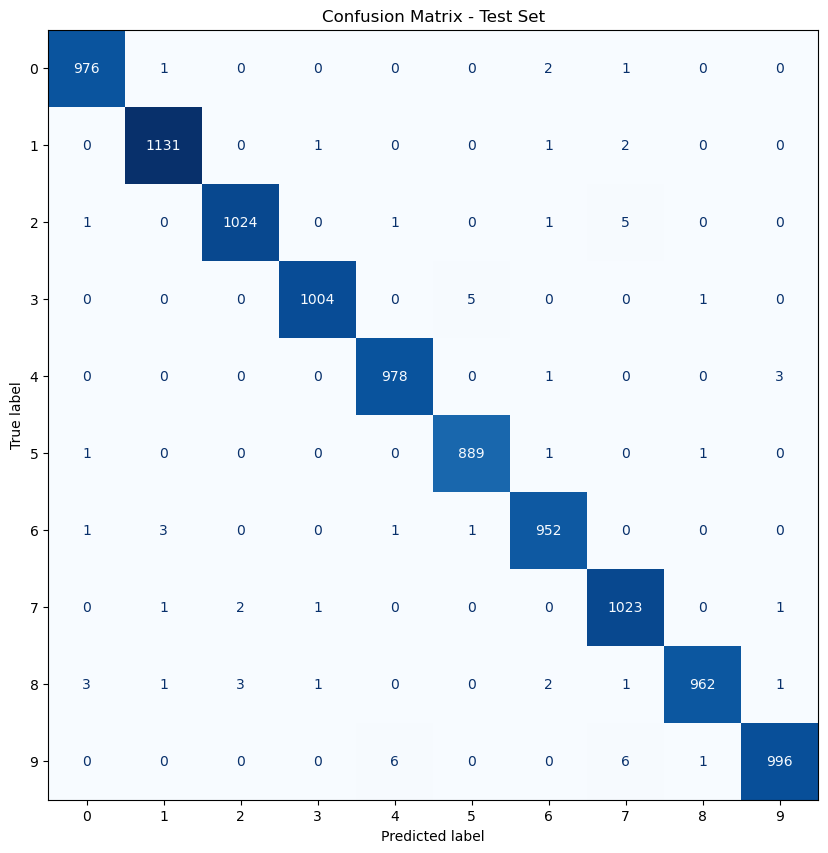

In [16]:
# Predicting the classes on the test set
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title("Confusion Matrix - Test Set")
plt.show()

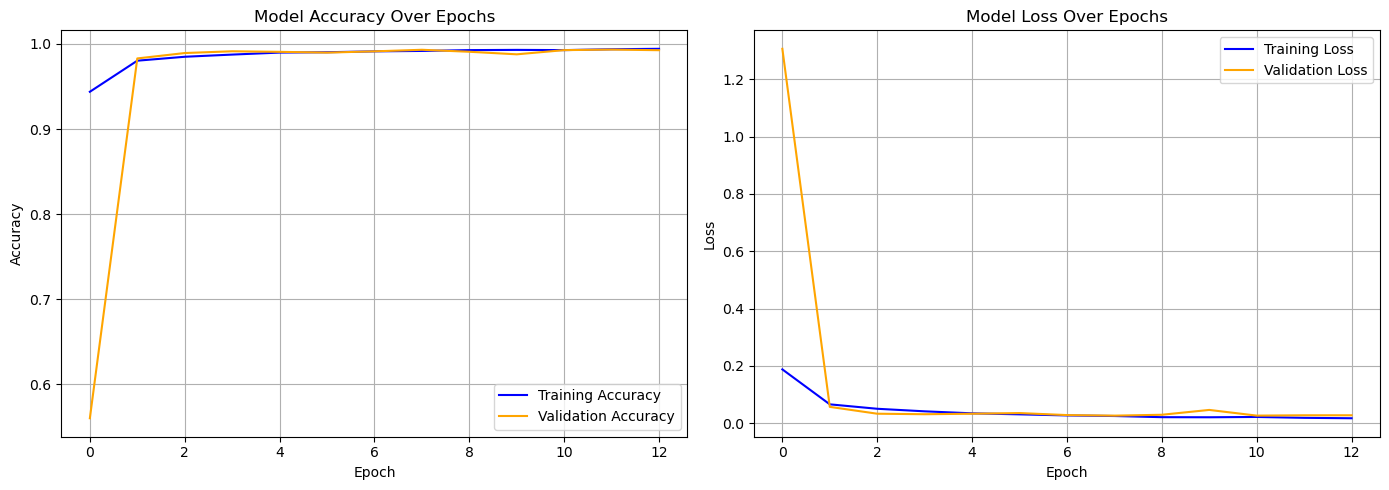

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color='blue')
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color='orange')
plt.title("Model Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color='blue')
plt.plot(history.history["val_loss"], label="Validation Loss", color='orange')
plt.title("Model Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

Filters shape: (3, 3, 1, 32)


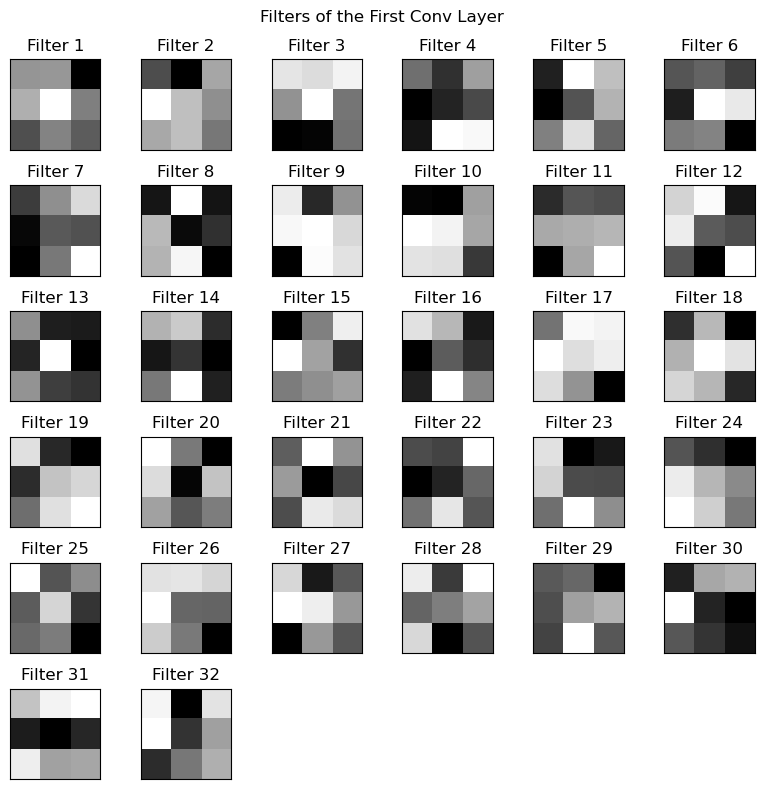

In [21]:
# Get weights of the first convolutional layer
filters, biases = model.layers[0].get_weights()
print(f"Filters shape: {filters.shape}")

# Normalize filter values to 0-1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the first 32 filters
n_filters, ix = 32, 1
plt.figure(figsize=(8, 8))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, 0, i]
    # plot each filter
    ax = plt.subplot(6, 6, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f, cmap="gray")
    plt.title(f"Filter {i+1}")
    ix += 1
plt.suptitle("Filters of the First Conv Layer")
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 31ms/step


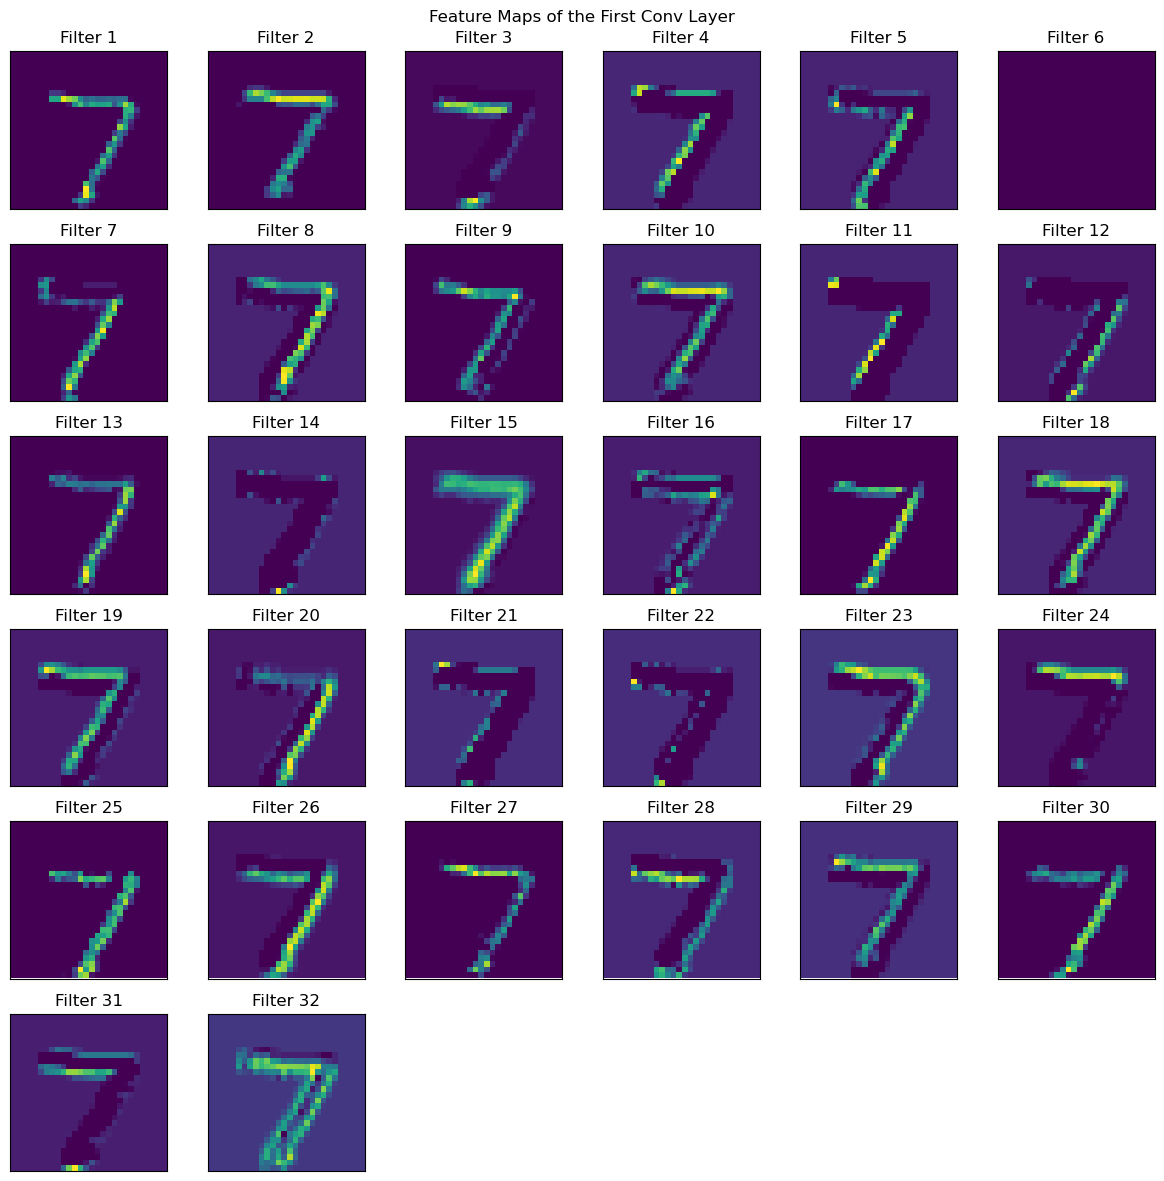

In [22]:
from tensorflow.keras.models import Model

# Create a model to output feature maps from the first convolutional layer
layer_outputs = [layer.output for layer in model.layers[:2]]  # First Conv Layer
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Select an image from the test set
test_image = X_test[0].reshape(1, 28, 28, 1)

# Get the feature maps
feature_maps = activation_model.predict(test_image)

# Plot the feature maps from the first Conv layer
first_layer_features = feature_maps[0]
num_features = first_layer_features.shape[-1]

plt.figure(figsize=(12, 12))
for i in range(num_features):
    ax = plt.subplot(6, 6, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(first_layer_features[0, :, :, i], cmap="viridis")
    plt.title(f"Filter {i+1}")
plt.suptitle("Feature Maps of the First Conv Layer")
plt.tight_layout()
plt.show()